# Experiment 4: Training Deep Networks (Loss, Backpropagation & Optimization)

Goals:
- Visualize activation functions: Sigmoid, ReLU, Tanh, Softmax
- Visualize loss functions: MSE, Cross-Entropy
- Implement backpropagation for a small MLP
- Compare optimizers (SGD, Momentum, Adam) on a small dataset

In [1]:
# Imports and setup
# If needed, uncomment to install: %pip install numpy matplotlib seaborn scikit-learn
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split

np.random.seed(42)
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_context('notebook')

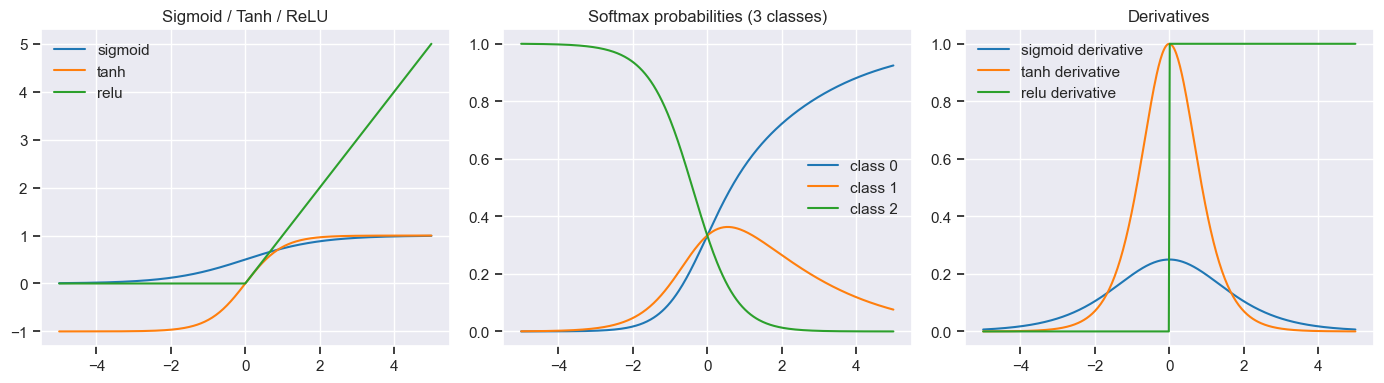

In [2]:
# Activation functions: Sigmoid, Tanh, ReLU, Softmax

def sigmoid(x):
    return 1/(1+np.exp(-x))

def tanh(x):
    return np.tanh(x)

def relu(x):
    return np.maximum(0, x)

def softmax(z):
    z = z - np.max(z, axis=1, keepdims=True)
    e = np.exp(z)
    return e / np.sum(e, axis=1, keepdims=True)

# Visualize activations
x = np.linspace(-5, 5, 400)
fig, axes = plt.subplots(1, 3, figsize=(14,4))
axes[0].plot(x, sigmoid(x), label='sigmoid')
axes[0].plot(x, tanh(x), label='tanh')
axes[0].plot(x, relu(x), label='relu')
axes[0].legend(); axes[0].set_title('Sigmoid / Tanh / ReLU')

# Softmax demo for 3-class logits patterns
Z = np.stack([x, 0.5*x, -x], axis=1)
P = softmax(Z)
axes[1].plot(x, P[:,0], label='class 0')
axes[1].plot(x, P[:,1], label='class 1')
axes[1].plot(x, P[:,2], label='class 2')
axes[1].legend(); axes[1].set_title('Softmax probabilities (3 classes)')

# Derivative shapes (for intuition)
axes[2].plot(x, sigmoid(x)*(1-sigmoid(x)), label='sigmoid derivative')
axes[2].plot(x, 1 - tanh(x)**2, label='tanh derivative')
axes[2].plot(x, (x>0).astype(float), label='relu derivative')
axes[2].legend(); axes[2].set_title('Derivatives')
plt.tight_layout(); plt.show()

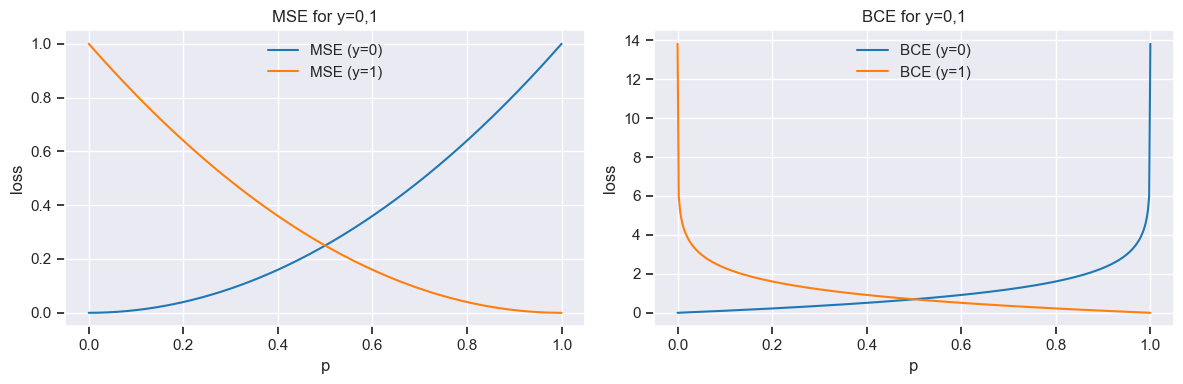

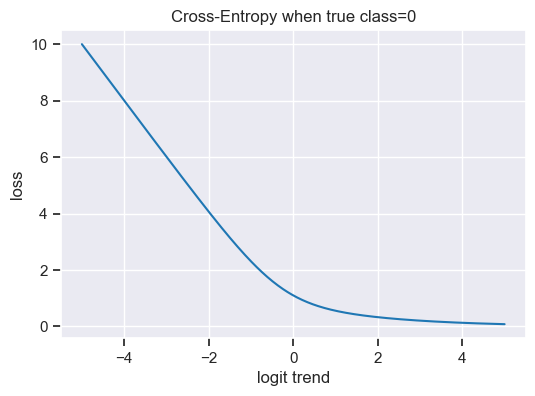

In [3]:
# Loss functions: MSE, Cross-Entropy (binary + multiclass)

def mse(y_true, y_pred):
    return np.mean((y_true - y_pred)**2)

def bce(y_true, y_prob, eps=1e-12):
    y_prob = np.clip(y_prob, eps, 1-eps)
    return -np.mean(y_true*np.log(y_prob) + (1-y_true)*np.log(1-y_prob))

def cross_entropy(y_true_onehot, y_prob, eps=1e-12):
    y_prob = np.clip(y_prob, eps, 1-eps)
    return -np.mean(np.sum(y_true_onehot * np.log(y_prob), axis=1))

# Visualize BCE vs MSE for binary classification
p = np.linspace(1e-6, 1-1e-6, 400)
fig, axes = plt.subplots(1, 2, figsize=(12,4))
axes[0].plot(p, (0 - p)**2, label='MSE (y=0)')
axes[0].plot(p, (1 - p)**2, label='MSE (y=1)')
axes[0].legend(); axes[0].set_title('MSE for y=0,1'); axes[0].set_xlabel('p'); axes[0].set_ylabel('loss')
axes[1].plot(p, -np.log(1-p), label='BCE (y=0)')
axes[1].plot(p, -np.log(p), label='BCE (y=1)')
axes[1].legend(); axes[1].set_title('BCE for y=0,1'); axes[1].set_xlabel('p'); axes[1].set_ylabel('loss')
plt.tight_layout(); plt.show()

# Visualize multiclass CE on simple 3-class softmax outputs
logits = np.stack([x, 0.5*x, -x], axis=1)
probs = softmax(logits)
y_true_one = np.zeros_like(probs); y_true_one[:,0] = 1  # class 0 true
ce_vals = -np.log(np.clip(probs[:,0], 1e-12, 1))
plt.figure(figsize=(6,4))
plt.plot(x, ce_vals)
plt.title('Cross-Entropy when true class=0'); plt.xlabel('logit trend'); plt.ylabel('loss')
plt.show()

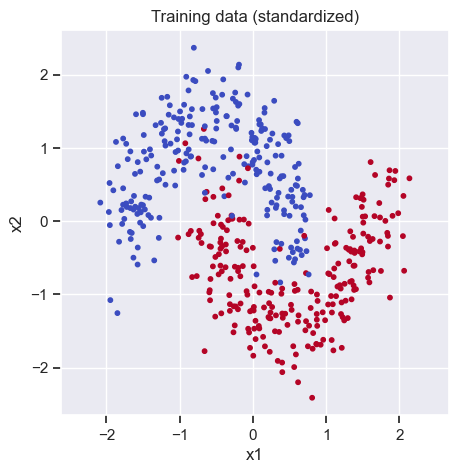

In [4]:
# Generate dataset (binary) and standardize
X, y = make_moons(n_samples=600, noise=0.2, random_state=42)
y = y.reshape(-1,1)
# Standardization (mean 0, std 1)
X_mean, X_std = X.mean(axis=0, keepdims=True), X.std(axis=0, keepdims=True) + 1e-8
Xn = (X - X_mean) / X_std
X_train, X_test, y_train, y_test = train_test_split(Xn, y, test_size=0.2, stratify=y, random_state=42)

plt.figure(figsize=(5,5))
plt.scatter(X_train[:,0], X_train[:,1], c=y_train.flatten(), cmap='coolwarm', s=10)
plt.title('Training data (standardized)'); plt.xlabel('x1'); plt.ylabel('x2'); plt.axis('equal')
plt.show()

In [5]:
# MLP with backprop and multiple optimizers (NumPy)

class MLP:
    def __init__(self, input_dim, h=32, lr=0.1, l2=0.0, optimizer='sgd', beta=0.9, beta2=0.999, eps=1e-8):
        self.lr, self.l2 = lr, l2
        self.optimizer, self.beta, self.beta2, self.eps = optimizer, beta, beta2, eps
        self.W1 = np.random.randn(input_dim, h) * np.sqrt(2/input_dim); self.b1 = np.zeros((1,h))
        self.W2 = np.random.randn(h, 1) * np.sqrt(2/h);           self.b2 = np.zeros((1,1))
        # Optimizer states
        self.vW1 = np.zeros_like(self.W1); self.vb1 = np.zeros_like(self.b1)
        self.vW2 = np.zeros_like(self.W2); self.vb2 = np.zeros_like(self.b2)
        self.mW1 = np.zeros_like(self.W1); self.mb1 = np.zeros_like(self.b1)
        self.mW2 = np.zeros_like(self.W2); self.mb2 = np.zeros_like(self.b2)
        self.t = 0
    def forward(self, X):
        z1 = X @ self.W1 + self.b1
        a1 = np.maximum(0, z1)
        z2 = a1 @ self.W2 + self.b2
        yhat = sigmoid(z2)
        return yhat, {"X":X, "z1":z1, "a1":a1, "z2":z2, "yhat":yhat}
    def loss(self, y, yhat):
        return bce(y, yhat) + 0.5*self.l2*(np.sum(self.W1**2)+np.sum(self.W2**2))
    def backward(self, cache, y):
        X, a1, yhat = cache['X'], cache['a1'], cache['yhat']
        m = X.shape[0]
        dz2 = (yhat - y)/m
        dW2 = a1.T @ dz2 + self.l2*self.W2
        db2 = np.sum(dz2, axis=0, keepdims=True)
        da1 = dz2 @ self.W2.T
        dz1 = da1 * (cache['z1'] > 0)
        dW1 = X.T @ dz1 + self.l2*self.W1
        db1 = np.sum(dz1, axis=0, keepdims=True)
        grads = (dW1, db1, dW2, db2)
        self._apply_updates(grads)
    def _apply_updates(self, grads):
        dW1, db1, dW2, db2 = grads
        if self.optimizer == 'sgd':
            self.W2 -= self.lr*dW2; self.b2 -= self.lr*db2
            self.W1 -= self.lr*dW1; self.b1 -= self.lr*db1
        elif self.optimizer == 'momentum':
            self.vW2 = self.beta*self.vW2 + (1-self.beta)*dW2; self.vb2 = self.beta*self.vb2 + (1-self.beta)*db2
            self.vW1 = self.beta*self.vW1 + (1-self.beta)*dW1; self.vb1 = self.beta*self.vb1 + (1-self.beta)*db1
            self.W2 -= self.lr*self.vW2; self.b2 -= self.lr*self.vb2
            self.W1 -= self.lr*self.vW1; self.b1 -= self.lr*self.vb1
        elif self.optimizer == 'adam':
            self.t += 1
            self.mW2 = self.beta*self.mW2 + (1-self.beta)*dW2; self.mb2 = self.beta*self.mb2 + (1-self.beta)*db2
            self.mW1 = self.beta*self.mW1 + (1-self.beta)*dW1; self.mb1 = self.beta*self.mb1 + (1-self.beta)*db1
            self.vW2 = self.beta2*self.vW2 + (1-self.beta2)*(dW2**2); self.vb2 = self.beta2*self.vb2 + (1-self.beta2)*(db2**2)
            self.vW1 = self.beta2*self.vW1 + (1-self.beta2)*(dW1**2); self.vb1 = self.beta2*self.vb1 + (1-self.beta2)*(db1**2)
            mW2_hat = self.mW2/(1-self.beta**self.t); mb2_hat = self.mb2/(1-self.beta**self.t)
            vW2_hat = self.vW2/(1-self.beta2**self.t); vb2_hat = self.vb2/(1-self.beta2**self.t)
            mW1_hat = self.mW1/(1-self.beta**self.t); mb1_hat = self.mb1/(1-self.beta**self.t)
            vW1_hat = self.vW1/(1-self.beta2**self.t); vb1_hat = self.vb1/(1-self.beta2**self.t)
            self.W2 -= self.lr*mW2_hat/(np.sqrt(vW2_hat)+self.eps); self.b2 -= self.lr*mb2_hat/(np.sqrt(vb2_hat)+self.eps)
            self.W1 -= self.lr*mW1_hat/(np.sqrt(vW1_hat)+self.eps); self.b1 -= self.lr*mb1_hat/(np.sqrt(vb1_hat)+self.eps)
        else:
            raise ValueError('Unknown optimizer')
    def predict(self, X):
        yhat,_ = self.forward(X)
        return (yhat>=0.5).astype(int)


In [6]:
# Training utilities

def accuracy(y_true, y_pred):
    return (y_true == y_pred).mean()

def fit_model(opt_name, lr=0.1, epochs=200, l2=1e-4, hidden=32):
    model = MLP(input_dim=2, h=hidden, lr=lr, l2=l2, optimizer=opt_name)
    losses, accs = [], []
    for ep in range(1, epochs+1):
        yhat, cache = model.forward(X_train)
        loss = model.loss(y_train, yhat)
        model.backward(cache, y_train)
        losses.append(loss)
        accs.append(accuracy(y_train, model.predict(X_train)))
    test_acc = accuracy(y_test, model.predict(X_test))
    return model, np.array(losses), np.array(accs), test_acc


SGD test accuracy: 0.917
MOMENTUM test accuracy: 0.908
ADAM test accuracy: 0.967


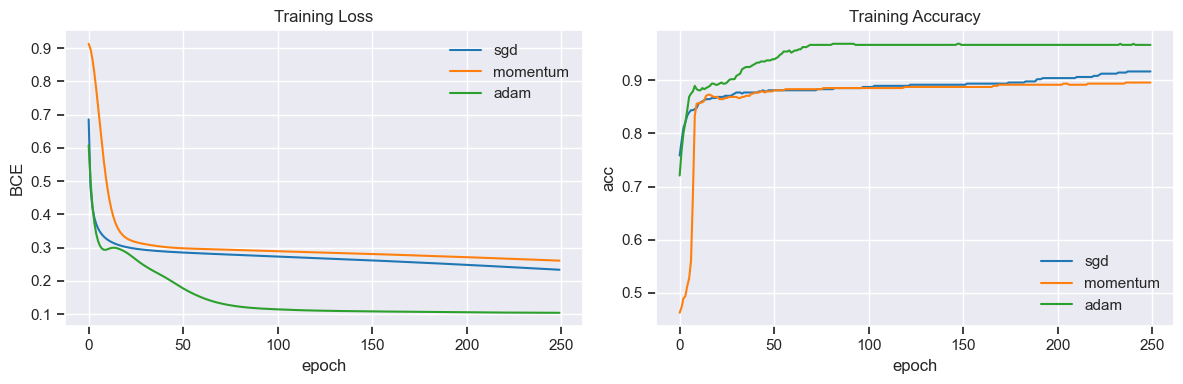

In [7]:
# Compare optimizers
opts = [('sgd', 0.2), ('momentum', 0.1), ('adam', 0.02)]
results = {}
for name, lr in opts:
    model, losses, accs, test_acc = fit_model(name, lr=lr, epochs=250)
    results[name] = dict(model=model, losses=losses, accs=accs, test_acc=test_acc)
    print(f"{name.upper()} test accuracy: {test_acc:.3f}")

# Plot loss and accuracy curves
fig, axes = plt.subplots(1, 2, figsize=(12,4))
for name in results:
    axes[0].plot(results[name]['losses'], label=name)
    axes[1].plot(results[name]['accs'], label=name)
axes[0].set_title('Training Loss'); axes[0].set_xlabel('epoch'); axes[0].set_ylabel('BCE')
axes[1].set_title('Training Accuracy'); axes[1].set_xlabel('epoch'); axes[1].set_ylabel('acc')
axes[0].legend(); axes[1].legend(); plt.tight_layout(); plt.show()


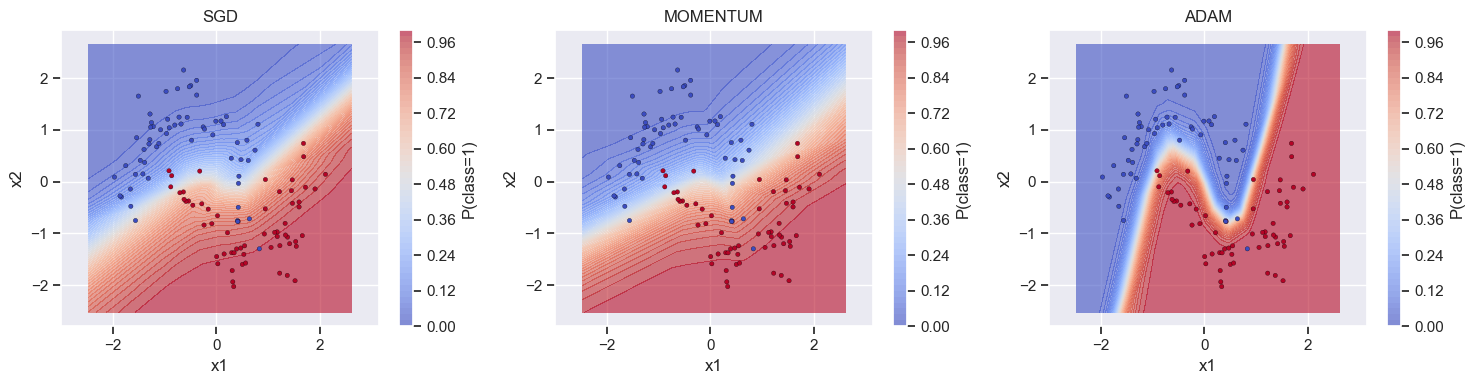

In [8]:
# Decision boundary plots for each optimizer

def plot_decision_boundary(model, X, y, steps=250):
    x_min, x_max = X[:,0].min()-0.5, X[:,0].max()+0.5
    y_min, y_max = X[:,1].min()-0.5, X[:,1].max()+0.5
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, steps), np.linspace(y_min, y_max, steps))
    grid = np.c_[xx.ravel(), yy.ravel()]
    yhat,_ = model.forward(grid)
    Z = yhat.reshape(xx.shape)
    plt.contourf(xx, yy, Z, levels=50, cmap='coolwarm', alpha=0.6)
    plt.colorbar(label='P(class=1)')
    plt.scatter(X[:,0], X[:,1], c=y.flatten(), cmap='coolwarm', s=10, edgecolor='k', linewidth=0.2)
    plt.xlabel('x1'); plt.ylabel('x2'); plt.axis('equal')

fig, axes = plt.subplots(1, 3, figsize=(15,4))
for ax, (name, res) in zip(axes, results.items()):
    plt.sca(ax)
    plot_decision_boundary(res['model'], X_test, y_test)
    plt.title(name.upper())
plt.tight_layout(); plt.show()